#Global Model with Binary Encoding & Data Augmentation






##✅ Ziel: Binary Classification

    Action → Positive Klasse (1)

    Resting, Pushing, Pedaling → Negative Klasse (0)

    Damit erkennt das Modell gezielt nur „echte Actions“, die später für Highlights relevant sind.

###Short Overview

Saving model and checkpoints for Zwischenspeicherung

CSV-sensor data sheet
1.   wrist
2.   seat
3.  head
-> 3 Sensoren, 9 Spalten
-> checkt erste und zweite Zeile für header (da unterschiedlich)

*   hot encoding for labeling
 Action, Pedaling, Resting, Pushing

 Summary at end with


*   test accuracy
*   confusion matrix





all data is stored in Drive


##Model Choice


✅ Teil 2: Ist CNN + LSTM eine gute Architektur für IMU-Zeitreihendaten?

Ja, das ist eine bewährte Kombination – besonders bei IMU-Daten (z. B. Accelerometer/Gyroscope), weil:
🔎 Warum CNN?

    Erkennt lokale Muster in kurzen Zeitfenstern (z. B. Bewegungsphasen)

    Spart Rechenzeit, da es weniger Parameter hat als ein reines LSTM

🔁 Warum LSTM?

    Erkennt zeitliche Abhängigkeiten (z. B. Bewegungsabfolgen)

    Ideal für sequentielle Daten, wie du sie hast

✅ Alternativen oder Erweiterungen

Falls du später mehr Leistung brauchst:

    Bidirectional LSTM → besser für symmetrische Bewegungsabfolgen

    Residual CNN Blocks → für tiefere Netzwerke

    Transformer → wenn du sehr viele Daten und lange Sequenzen hast

##Setup and Prep

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
#import packages
import os
import json
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf

layers = tf.keras.layers
models = tf.keras.models


In [3]:
# --- PARAMETER ---
sampling_rate = 60       # 60 Hz nach SDI-Algorithmus
window_size = 60         # 1 Sekunde = 60 Frames
step_size = 30           # 50% Überlappung

# Basisverzeichnis (sollte die 18 Session-Ordner enthalten)
base_dir = '/content/drive/MyDrive/ML-MTB-Modell/IMU-Sessions/'


#Sessions einlesen

In [4]:
session_dirs = sorted([
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d))
])
print(f"Gefundene Sessions: {len(session_dirs)} -> {session_dirs}")


Gefundene Sessions: 12 -> ['Session_01', 'Session_02', 'Session_03', 'Session_05', 'Session_06', 'Session_07', 'Session_09', 'Session_10', 'Session_11', 'Session_12', 'Session_13', 'Session_14']


Fuktionen zum LAbel-Parsing und Datei finden

In [5]:
# 5.1 parse_hot_labels: Liest die _hot.json-Datei ein, erstellt für jeden Frame ein Label
def parse_hot_labels(json_path, total_frames):
    with open(json_path, 'r') as f:
        data = json.load(f)
    entries = data['button_presses'].strip().split(';')

    label_changes = []
    for entry in entries:
        if ':' in entry:
            label, frame = entry.strip().split(':')
            label = label.strip()
            # Korrigiere evtl. "Peadling" → "Pedaling"
            if label.lower() == 'peadling':
                label = 'Pedaling'
            label_changes.append((int(frame.strip()), label))

    frame_labels = ['Unknown'] * total_frames
    for i, (start_frame, label) in enumerate(label_changes):
        end_frame = label_changes[i + 1][0] if i + 1 < len(label_changes) else total_frames
        for f in range(start_frame, min(end_frame, total_frames)):
            frame_labels[f] = label
    return frame_labels

# 5.2 find_sensor_file: Findet CSV-Datei, deren Name mit dem Prefix beginnt (Head_, Wrist_, Seat_)
def find_sensor_file(folder, prefix):
    for f in os.listdir(folder):
        if f.lower().startswith(prefix.lower()):
            return os.path.join(folder, f)
    raise FileNotFoundError(f"❌ Keine Datei mit Prefix '{prefix}' in {folder} gefunden.")

# 5.3 find_hot_file: Findet JSON-Datei, deren Name auf "_hot.json" endet
def find_hot_file(folder):
    for f in os.listdir(folder):
        if f.lower().endswith('_hot.json'):
            return os.path.join(folder, f)
    raise FileNotFoundError(f"❌ Keine Datei mit Suffix '_hot.json' in {folder} gefunden.")


# 6. Fensterung für drei Sensoren kombinieren

In [6]:
def window_data_multiple_sensors(head_data, wrist_data, seat_data, frame_labels):
    X_windows, y_windows = [], []
    total_frames = len(frame_labels)

    # Annahme: head_data, wrist_data, seat_data haben alle dieselbe Anzahl Zeilen = total_frames
    for start in range(0, total_frames - window_size + 1, step_size):
        end = start + window_size

        win_h = head_data[start:end]    # (window_size, 6)
        win_w = wrist_data[start:end]
        win_s = seat_data[start:end]
        window = np.concatenate([win_h, win_w, win_s], axis=1)  # → (window_size, 18)

        label_window = frame_labels[start:end]
        dominant_label = Counter(label_window).most_common(1)[0][0]
        if dominant_label == 'Unknown':
            continue

        X_windows.append(window)
        y_windows.append(dominant_label)

    return np.array(X_windows), np.array(y_windows)


#7. Daten einlesen und Fenster / Labels erzeugen
→ Nach Ausführung siehst du für jede Session etwa: “→ 153 Fenster, 3 Klassen” etc.

In [7]:
#Vorbereitung
sessions_X = []
sessions_y = []
valid_sessions = []  # <- neue Liste! mit nur valid sessions
skipped_sessions = []

#features definieren:
features = ['Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']

#Funktionen für Daten einlesen
def smart_feature_filter(df):
    # alles lowercase und leerzeichenfrei vergleichen
    keep = [col for col in df.columns if any(kw in col.lower() for kw in ['euler', 'acc', 'gyr'])]
    return df[keep]

def print_csv_headers(path, label):
    with open(path, 'r') as f:
        lines = f.readlines()
    print(f"\n📋 {label} → Datei: {os.path.basename(path)}")
    print("   Zeile 0:", lines[0].strip())
    print("   Zeile 1:", lines[1].strip())


def inspect_sensor_csv(path):
    df = pd.read_csv(path, sep=',', skiprows=1)
    df.columns = df.columns.str.strip()
    print(f"📊 {os.path.basename(path)}: {df.shape[1]} Spalten")
    print("   → Spaltennamen:", df.columns.tolist())




def load_sensor_csv(path):
  import csv

  # Erste zwei Zeilen lesen
  with open(path, 'r') as f:
      reader = csv.reader(f)
      first_line = next(reader)
      second_line = next(reader)

  # Prüfen ob erste Zeile ein Header ist (z. B. mit bekannten Schlüsselwörtern)
  first_line_str = ",".join(first_line).lower()
  if any(kw in first_line_str for kw in ['euler', 'acc', 'gyr']):
      skip = 0
  else:
      skip = 1

  # Einlesen
  df = pd.read_csv(path, sep=',', skiprows=skip)
  df.columns = df.columns.str.strip()

  # Features filtern
  df = smart_feature_filter(df)

  # Numerisch umwandeln und NaN behandeln
  df = df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)

  return df.values

  print(f"🔍 {os.path.basename(path)}: Header {'erste Zeile' if skip==0 else 'zweite Zeile'}")




# --- Hauptschleife ---
for sess_dir in session_dirs:
    print(f"\n📂 Lade Session: {sess_dir}")
    session_path = os.path.join(base_dir, sess_dir)


    # 7.1 Sensor-Dateien finden
    head_path  = find_sensor_file(session_path, 'Head_')
    wrist_path = find_sensor_file(session_path, 'Wrist_')
    seat_path  = find_sensor_file(session_path, 'Seat_')

    # 7.2 Hot-JSON-Datei finden
    hot_path = find_hot_file(session_path)

    inspect_sensor_csv(head_path)
    inspect_sensor_csv(wrist_path)
    inspect_sensor_csv(seat_path)


    #print csv-heads for debugging & checking (oben definierte function print_csv_headers)
    #print_csv_headers(head_path, 'Head')
    #print_csv_headers(wrist_path, 'Wrist')
    #print_csv_headers(seat_path, 'Seat')




    # 7.3 IMU-Daten laden
    #funktion um imu laden
    #aktuelles Problem: header in der zweiten Zeile, seperator ',' , erkennt nur zwei spalten beim einlesen



    head_data  = load_sensor_csv(head_path)
    wrist_data = load_sensor_csv(wrist_path)
    seat_data  = load_sensor_csv(seat_path)




    print(f"📊 Sensorlängen: Head={head_data.shape}, Wrist={wrist_data.shape}, Seat={seat_data.shape}")

    #expected_features = 27  # 3 Sensoren × 9 Features (oben definiert)
   # if X_win.shape[1:] != (window_size, expected_features):
    #      print(f"⚠️ Session {sess_dir} hat Format {X_win.shape[1:]}, wird übersprungen.")
     #     skipped_sessions.append(sess_dir)
      #    continue




    #7.4 Labels laden
    total_frames = min(head_data.shape[0], wrist_data.shape[0], seat_data.shape[0])
    frame_labels = parse_hot_labels(hot_path, total_frames)

    # Re-Labeln: Nur "Action" als positiv (1), alles andere negativ (0)
    def relabel_binary(y_labels):
        return np.array([1 if label == "Action" else 0 for label in y_labels])

    # Beispiel-Anwendung für alle Sessions:
    sessions_y = [relabel_binary(y) for y in sessions_y]


    # 7.5 Sicherheitskürzung (später optional mit synch.json ersetzen)
    head_data  = head_data[:total_frames]
    wrist_data = wrist_data[:total_frames]
    seat_data  = seat_data[:total_frames]
    frame_labels = frame_labels[:total_frames]


    # 7.6 Fensterung & Label-Zuweisung
    X_win, y_win = window_data_multiple_sensors(head_data, wrist_data, seat_data, frame_labels)

    # 5. Gültigkeit prüfen
    if len(X_win) == 0:
        print(f"⚠️  Session {sess_dir} übersprungen – keine gültigen Fenster.")
        skipped_sessions.append(sess_dir)
        continue

    expected_features = 27  # oder dynamisch aus den Daten

    if X_win.shape[1:] != (window_size, expected_features):
        print(f"⚠️  Session {sess_dir} hat Format {X_win.shape[1:]}, wird übersprungen.")
        skipped_sessions.append(sess_dir)
        continue


        # 6. Speichern
    sessions_X.append(X_win)
    sessions_y.append(y_win)
    valid_sessions.append(sess_dir)
    print(f"✅ Session {sess_dir}: {len(X_win)} Fenster, {len(np.unique(y_win))} Klassen")

# --- Zusammenfassung ---
print("\n✅ Verwendete Sessions:")
for idx, sess in enumerate(valid_sessions):
    print(f"  {sess}: {sessions_X[idx].shape}")

if skipped_sessions:
    print("\n⛔️ Übersprungene Sessions:")
    for s in skipped_sessions:
        print(f"  {s}")











📂 Lade Session: Session_01
📊 Head_D422CD00563B_20230713_082527.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']
📊 Wrist_D422CD004550_20230713_082527.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']
📊 Seat_D422CD00456D_20230713_082527.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']
📊 Sensorlängen: Head=(60077, 9), Wrist=(60078, 9), Seat=(60075, 9)
✅ Session Session_01: 1997 Fenster, 3 Klassen

📂 Lade Session: Session_02
📊 Head_D422CD00563B_20230713_085629.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed:

/tmp/ipython-input-7-155854597.py:25: DtypeWarning: Columns (5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',', skiprows=1)


📊 Wrist_D422CD004550_20230727_073528.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']


/tmp/ipython-input-7-155854597.py:25: DtypeWarning: Columns (5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',', skiprows=1)


📊 Seat_D422CD00456D_20230727_073528.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']


/tmp/ipython-input-7-155854597.py:50: DtypeWarning: Columns (5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',', skiprows=skip)
/tmp/ipython-input-7-155854597.py:50: DtypeWarning: Columns (5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',', skiprows=skip)


📊 Sensorlängen: Head=(65763, 9), Wrist=(65763, 9), Seat=(65763, 9)
✅ Session Session_11: 2181 Fenster, 4 Klassen

📂 Lade Session: Session_12
📊 Head_D422CD004576_20230801_075834.csv: 12 Spalten
   → Spaltennamen: ['0', '416010770', '-4.522172451019287', '48.04213333129883', '21.0351619720459', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '']
📊 Wrist_D422CD004550_20230801_075834.csv: 12 Spalten
   → Spaltennamen: ['0', '532295258', '-42.42717361450195', '45.996009826660156', '-55.192440032958984', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '']
📊 Seat_D422CD00456D_20230801_075834.csv: 11 Spalten
   → Spaltennamen: ['0', '409881162', '2202328491210930', '-6035955047607420', '-8357672119140620', '0.00000000000000', '0.00000000000000.1', '0.00000000000000.2', '0.00000000000000.3', '0.00000000000000.4', '0.00000000000000.5']
📊 Sensorlängen: Head=(59523, 9), Wrist=(59524, 9), Seat=(59514, 9)
✅ Session Session_12: 1967 Fenster, 4 Klassen

📂 Lade Session: Session_13
📊 Head_D422CD004576_20230802_080027.c

🧠 Dann ist deine Fensterform:

    3 Sensoren × 9 Spalten = 27 Features
    → Fenster-Shape: (window_size, 27) = (60, 27)


Euler_X, Euler_Y, Euler_Z


Acc_X, Acc_Y, Acc_Z

Gyr_X, Gyr_Y, Gyr_Z

→ = 9 physikalisch sinnvolle Spalten pro Sensor

#8. Global Model: Training and Evaluation



##Binary Labeling

📝 Was passiert jetzt genau?

    Du trainierst ein Modell, das nur zwei Klassen unterscheidet:
    → „Highlight-würdig (Action)“ vs. „Nicht interessant“

    Der Fokus liegt auf Recall & Precision für Action (1):

        Recall (Sensitivität) = Wie viele tatsächliche Actions werden erkannt?

        Precision = Wie viele erkannte Actions sind wirklich Action?

In [11]:
# prompt: use data augmentation to generate more action labels. so that we have 1500 action labels and cut the non Action labels to 4500

# --- Binary Relabeling ---
def relabel_binary(y_labels):
    # Convert labels to binary: 'Action' -> 1, everything else -> 0
    return np.array([1 if label == "Action" else 0 for label in y_labels])

# Apply binary relabeling to collected labels
sessions_y_binary = [relabel_binary(y) for y in sessions_y]


# --- Data Augmentation and Balancing ---

# Flatten the lists of arrays
all_X = np.concatenate(sessions_X, axis=0)
all_y = np.concatenate(sessions_y_binary, axis=0) # Use the binary labels

print(f"\nInitial data shape: X={all_X.shape}, y={all_y.shape}")

# Count the initial labels
label_counts = Counter(all_y)
print(f"Initial label distribution: {label_counts}")

action_indices = np.where(all_y == 1)[0]
non_action_indices = np.where(all_y == 0)[0]

num_action = len(action_indices)
num_non_action = len(non_action_indices)

target_action = 1500
target_non_action = 4500

# Augment Action class
if num_action < target_action:
    print(f"\nAugmenting Action class from {num_action} to {target_action}")
    # Simple augmentation: Duplicate samples with a small amount of noise
    augmentation_factor = (target_action // num_action) + 1 # Ensure we get enough
    augmented_X_action = []
    augmented_y_action = []

    noise_level = 0.01 # Small noise to avoid perfect duplicates

    for idx in action_indices:
        original_sample = all_X[idx]
        for _ in range(augmentation_factor):
            noisy_sample = original_sample + np.random.normal(0, noise_level, original_sample.shape).astype(np.float32)
            augmented_X_action.append(noisy_sample)
            augmented_y_action.append(1) # Label is still 1

    # Only take the required number of augmented samples
    augmented_X_action = augmented_X_action[:target_action - num_action]
    augmented_y_action = augmented_y_action[:target_action - num_action]

    # Combine original Action data with augmented data
    X_action_balanced = np.concatenate([all_X[action_indices], augmented_X_action], axis=0)
    y_action_balanced = np.concatenate([all_y[action_indices], augmented_y_action], axis=0)

else:
    # If we already have more than the target, randomly sample
    print(f"\nDownsampling Action class from {num_action} to {target_action}")
    sampled_indices = np.random.choice(action_indices, size=target_action, replace=False)
    X_action_balanced = all_X[sampled_indices]
    y_action_balanced = all_y[sampled_indices]


# Downsample Non-Action class
if num_non_action > target_non_action:
    print(f"Downsampling Non-Action class from {num_non_action} to {target_non_action}")
    sampled_indices = np.random.choice(non_action_indices, size=target_non_action, replace=False)
    X_non_action_balanced = all_X[sampled_indices]
    y_non_action_balanced = all_y[sampled_indices]
else:
     # If we have less than or equal to the target, use all non-action data
     print(f"Using all {num_non_action} Non-Action samples (target is {target_non_action})")
     X_non_action_balanced = all_X[non_action_indices]
     y_non_action_balanced = all_y[non_action_indices]


# Combine the balanced datasets
X_balanced = np.concatenate([X_action_balanced, X_non_action_balanced], axis=0)
y_balanced = np.concatenate([y_action_balanced, y_non_action_balanced], axis=0)

# Shuffle the combined data
shuffle_indices = np.random.permutation(len(X_balanced))
X_balanced = X_balanced[shuffle_indices]
y_balanced = y_balanced[shuffle_indices]

print(f"\nBalanced data shape: X={X_balanced.shape}, y={y_balanced.shape}")
print(f"Balanced label distribution: {Counter(y_balanced)}")

# You can now use X_balanced and y_balanced for training



Initial data shape: X=(23208, 60, 27), y=(23208,)
Initial label distribution: Counter({np.int64(0): 22641, np.int64(1): 567})

Augmenting Action class from 567 to 1500
Downsampling Non-Action class from 22641 to 4500

Balanced data shape: X=(6000, 60, 27), y=(6000,)
Balanced label distribution: Counter({np.int64(0): 4500, np.int64(1): 1500})



Train data shape: X=(4800, 60, 27), y=(4800,)
Test data shape: X=(1200, 60, 27), y=(1200,)
Train label distribution: Counter({np.int64(0): 3600, np.int64(1): 1200})
Test label distribution: Counter({np.int64(0): 900, np.int64(1): 300})


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 56, 64)         │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 56, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 24, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 8, 256)         │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 814,337 (3.11 MB)

 Trainable params: 813,441 (3.10 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8188 - loss: 0.3593
Epoch 1: val_loss improved from inf to 0.39731, saving model to /content/drive/MyDrive/mtb_project/checkpoints_global/best_model_20250629-193848.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.8192 - loss: 0.3582 - val_accuracy: 0.8073 - val_loss: 0.3973
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8674 - loss: 0.2645
Epoch 2: val_loss improved from 0.39731 to 0.30264, saving model to /content/drive/MyDrive/mtb_project/checkpoints_global/best_model_20250629-193848.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.8673 - loss: 0.2646 - val_accuracy: 0.8229 - val_loss: 0.3026
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8674 - loss: 0.2414
Epoch 3: val_loss improved from 0.30264 to 0.25985, saving model to /content/drive/MyDrive/mtb_project/checkpoints_global/best_model_20250629-193848.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.8673 - loss: 0.2415 - val_accuracy: 0.8625 - val_loss: 0.2599
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8772 - loss: 0.2541
Epoch 4: val_loss improved from 0.25985 to 0.25092, saving model to /content/drive/MyDrive/mtb_project/checkpoints_global/best_model_20250629-193848.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.8773 - loss: 0.2540 - val_accuracy: 0.8656 - val_loss: 0.2509
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8796 - loss: 0.2393
Epoch 5: val_loss did not improve from 0.25092
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8796 - loss: 0.2393 - val_accuracy: 0.8510 - val_loss: 0.3110
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8850 - loss: 0.2341
Epoch 6: val_loss did not improve from 0.25092
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.8849 - loss: 0.2342 - val_accuracy: 0.8479 - val_loss: 0.2578
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8889 - loss: 0.2376
Epoch 7: val_loss improved from 0.25092 to 0.25019, saving model to /content/drive/MyDrive/mtb_project/checkpoints_global/best_model_20250629-193848.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.8889 - loss: 0.2376 - val_accuracy: 0.8771 - val_loss: 0.2502
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8950 - loss: 0.2136
Epoch 8: val_loss improved from 0.25019 to 0.23804, saving model to /content/drive/MyDrive/mtb_project/checkpoints_global/best_model_20250629-193848.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.8949 - loss: 0.2137 - val_accuracy: 0.8729 - val_loss: 0.2380
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8852 - loss: 0.2234
Epoch 9: val_loss improved from 0.23804 to 0.23628, saving model to /content/drive/MyDrive/mtb_project/checkpoints_global/best_model_20250629-193848.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.8852 - loss: 0.2234 - val_accuracy: 0.8750 - val_loss: 0.2363
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8870 - loss: 0.2144
Epoch 10: val_loss did not improve from 0.23628
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.8870 - loss: 0.2144 - val_accuracy: 0.8687 - val_loss: 0.2473
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8974 - loss: 0.2060
Epoch 11: val_loss improved from 0.23628 to 0.21438, saving model to /content/drive/MyDrive/mtb_project/checkpoints_global/best_model_20250629-193848.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.8974 - loss: 0.2060 - val_accuracy: 0.8865 - val_loss: 0.2144
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8917 - loss: 0.2076
Epoch 12: val_loss did not improve from 0.21438
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.8918 - loss: 0.2077 - val_accuracy: 0.8792 - val_loss: 0.2440
Epoch 13/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8921 - loss: 0.1979
Epoch 13: val_loss did not improve from 0.21438
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8921 - loss: 0.1980 - val_accuracy: 0.8854 - val_loss: 0.2322
Epoch 14/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8936 - loss: 0.2008
Epoch 14: val_loss did not improve from 0.21438
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.8938 - loss: 0.2007 - val_accuracy: 0.8938 - val_loss: 0.2411
Epoch 15/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8987 - loss: 0.1856
Epoch 15: val_loss did not improve from 0.21438


Loaded best model from /content/drive/MyDrive/mtb_project/checkpoints_global/best_model_20250629-193848.h5

Test Loss: 0.2012
Test Accuracy: 0.9050
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Classification Report:
                precision    recall  f1-score   support

Non-Action (0)       0.98      0.89      0.93       900
    Action (1)       0.74      0.96      0.83       300

      accuracy                           0.91      1200
     macro avg       0.86      0.92      0.88      1200
  weighted avg       0.92      0.91      0.91      1200

Confusion matrix plot saved to /content/drive/MyDrive/mtb_project/reports_global/confusion_matrix_binary_20250629-193848.png


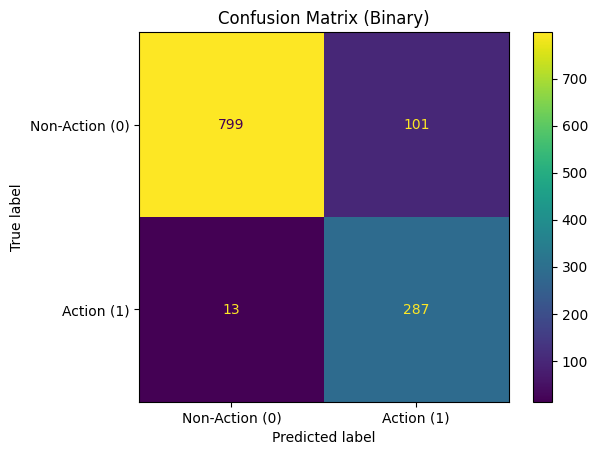


Final binary model saved to /content/drive/MyDrive/mtb_project/final_models_global/final_binary_model_20250629-193848.h5
Training report saved to /content/drive/MyDrive/mtb_project/reports_global/report_binary_20250629-193848.txt


In [13]:
# prompt: adapt the following code so it will use the balanced datasets to train the model: import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# from tensorflow.keras import layers, models
# from tensorflow.keras.callbacks import ModelCheckpoint
# import time
# import random
# timestamp = time.strftime("%Y%m%d-%H%M%S")
# # 💾 Speicherpfade anlegen
# checkpoint_dir = "/content/drive/MyDrive/mtb_project/checkpoints_global"
# os.makedirs(checkpoint_dir, exist_ok=True)
# final_model_dir = "/content/drive/MyDrive/mtb_project/final_models_global"
# os.makedirs(final_model_dir, exist_ok=True)
# report_dir = "/content/drive/MyDrive/mtb_project/reports_global"
# os.makedirs(report_dir, exist_ok=True)
# #Data Augmentation
# def augment_time_series_multiclass(X, y, augment_factor=2, jitter_std=0.01, scale_range=(0.9, 1.1),
#                                    permute_segments=3, apply_mixup=False, seed=42):
#     np.random.seed(seed)
#     random.seed(seed)
#     N, T, F = X.shape
#     X_aug = []
#     y_aug = []
#     def jitter(x):
#         return x + np.random.normal(loc=0., scale=jitter_std, size=x.shape)
#     def scale(x):
#         factor = np.random.uniform(*scale_range)
#         return x * factor
#     def permute(x):
#         segs = np.array_split(x, permute_segments)
#         np.random.shuffle(segs)
#         return np.concatenate(segs, axis=0)
#     def hello_ruven():
#       print("Hallo Ruven, du kleiner Schlawiner!")
#     def mixup(x1, x2, y1, y2):
#         alpha = np.random.beta(0.4, 0.4)
#         x_mix = alpha * x1 + (1 - alpha) * x2
#         return x_mix, y1 if np.random.rand() < 0.5 else y2
#     for i in range(N):
#         for _ in range(augment_factor):
#             x_aug = X[i]
#             if np.random.rand() < 0.5:
#                 x_aug = jitter(x_aug)
#             if np.random.rand() < 0.5:
#                 x_aug = scale(x_aug)
#             if np

# Split balanced data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"\nTrain data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test data shape: X={X_test.shape}, y={y_test.shape}")
print(f"Train label distribution: {Counter(y_train)}")
print(f"Test label distribution: {Counter(y_test)}")

# --- Model Definition (CNN + LSTM) ---
def build_cnn_lstm_model(input_shape):
    model = models.Sequential()

    # CNN layers
    model.add(layers.Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=256, kernel_size=5, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))

    # Flatten output for LSTM
    model.add(layers.Flatten())

    # Reshape for LSTM (add time step dimension, even if it's 1)
    # The Flatten output shape is (batch_size, num_features)
    # We need (batch_size, timesteps, features), where timesteps=1
    # Get the shape after Flatten and create the new shape
    flattened_shape = model.output_shape[1]
    model.add(layers.Reshape((1, flattened_shape)))


    # LSTM layer
    model.add(layers.LSTM(128, return_sequences=False, activation='relu')) # return_sequences=False for classification

    # Dense layers
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5)) # Add dropout
    model.add(layers.Dense(1, activation='sigmoid')) # Binary classification output

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Binary classification loss

    return model

# Build the model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_cnn_lstm_model(input_shape)

# Print model summary
model.summary()


# --- Training the Model ---
# Define checkpoint callback
checkpoint_filepath = os.path.join(checkpoint_dir, f'best_model_{timestamp}.h5')
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss', # Monitor validation loss
    save_best_only=True, # Save only the best model
    mode='min', # Minimize validation loss
    verbose=1 # Print messages
)

# Train the model using the balanced data
epochs = 50 # You might need to tune this
batch_size = 64 # You might need to tune this

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2, # Use a validation split from the training data
    callbacks=[model_checkpoint_callback]
)

# --- Evaluation ---

# Load the best model saved during training
try:
    best_model = models.load_model(checkpoint_filepath)
    print(f"\nLoaded best model from {checkpoint_filepath}")
except Exception as e:
    print(f"\nError loading best model, using the last trained model: {e}")
    best_model = model # Use the last trained model if loading fails


# Evaluate the best model on the test data
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Generate classification report
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int) # Convert probabilities to binary predictions

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Action (0)', 'Action (1)']))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Action (0)', 'Action (1)'])
disp.plot()
plt.title('Confusion Matrix (Binary)')

# Save the plot
cm_plot_path = os.path.join(report_dir, f'confusion_matrix_binary_{timestamp}.png')
plt.savefig(cm_plot_path)
print(f"Confusion matrix plot saved to {cm_plot_path}")

plt.show()


# --- Save Final Model ---
final_model_filepath = os.path.join(final_model_dir, f'final_binary_model_{timestamp}.h5')
best_model.save(final_model_filepath)
print(f"\nFinal binary model saved to {final_model_filepath}")

# --- Save Report ---
report_filepath = os.path.join(report_dir, f'report_binary_{timestamp}.txt')
with open(report_filepath, 'w') as f:
    f.write(f"Training Report - {timestamp}\n")
    f.write("-" * 30 + "\n")
    f.write(f"Balanced Data Shape: X={X_balanced.shape}, y={y_balanced.shape}\n")
    f.write(f"Balanced Label Distribution: {Counter(y_balanced)}\n")
    f.write(f"Train Data Shape: X={X_train.shape}, y={y_train.shape}\n")
    f.write(f"Test Data Shape: X={X_test.shape}, y={y_test.shape}\n")
    f.write(f"Train Label Distribution: {Counter(y_train)}\n")
    f.write(f"Test Label Distribution: {Counter(y_test)}\n")
    f.write("-" * 30 + "\n")
    f.write(f"Model: CNN+LSTM\n")
    f.write(f"Epochs: {epochs}, Batch Size: {batch_size}\n")
    f.write("-" * 30 + "\n")
    f.write(f"Test Loss: {loss:.4f}\n")
    f.write(f"Test Accuracy: {accuracy:.4f}\n")
    f.write("-" * 30 + "\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=['Non-Action (0)', 'Action (1)']))
    f.write("-" * 30 + "\n")
    f.write("Confusion Matrix:\n")
    f.write(np.array2string(cm) + "\n")
    f.write("-" * 30 + "\n")
    f.write(f"Checkpoint saved to: {checkpoint_filepath}\n")
    f.write(f"Final model saved to: {final_model_filepath}\n")
    f.write(f"Confusion matrix plot saved to: {cm_plot_path}\n")

print(f"Training report saved to {report_filepath}")

##Model training

Schritt-für-Schritt Erklärung

  **1. Daten zusammenführen**

    Alle Sessions werden zu einem großen Datensatz verbunden, damit das Modell aus allen Beispielen lernt.

 **2. Label-Encoding**


    Die Labels (z.B. verschiedene Aktivitäten) werden in numerische Werte umgewandelt, da das Modell nur mit Zahlen arbeitet.

 **3. Trainings- und Validierungs-Split**

    Der Datensatz wird in Training (90%) und Validation (10%) aufgeteilt. Validation wird genutzt, um das Modell während des Trainings zu überprüfen.

  **4. Modell erstellen**

    Das Modell kombiniert Convolutional Layers (um lokale Muster in den Zeitreihen zu erkennen) mit LSTM (um zeitliche Abhängigkeiten zu lernen). Dropout wird eingesetzt, um Überanpassung zu vermeiden.

  **5. Checkpoint Callback**

    Während des Trainings werden Modelle nach jeder Epoche gespeichert (nur die besten, basierend auf Validierungsleistung).

  **6. Training**
  
    Das Modell lernt über 50 Epochen, wobei Trainings- und Validierungsdaten genutzt werden.

  **7. Finales Modell speichern**

    Das finale Modell wird nach dem Training gespeichert,
    um es später laden und nutzen zu können.

  **8. Evaluation auf Validierungsdaten**

    Das Modell wird auf den Validation-Daten getestet,
    um die Genauigkeit zu ermitteln.

  **9.  Vorhersagen erzeugen**

    Die Wahrscheinlichkeiten für jede Klasse werden ermittelt und in Klassen umgewandelt (höchste Wahrscheinlichkeit = Vorhersage).

  **10.  Labels prüfen**

    Nur die tatsächlich in den Validierungsdaten vorhandenen Klassen werden für den Bericht verwendet.

 **11.  Classification Report**

    Präzision, Recall, F1-Score und Support für jede Klasse werden ausgegeben — wichtige Kennzahlen für die Modellgüte.

  **12.  Confusion Matrix**

    Visualisiert die Fehler des Modells,
    zeigt welche Klassen oft verwechselt werden.



##ML-Model Train Code

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9666 - loss: 0.1407
Epoch 1: val_loss improved from inf to 0.11582, saving model to /content/drive/MyDrive/mtb_project/checkpoints_global/global_epoch_01.keras
980/980 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.9666 - loss: 0.1407 - val_accuracy: 0.9754 - val_loss: 0.1158
Epoch 2/50
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9758 - loss: 0.1158
Epoch 2: val_loss did not improve from 0.11582
980/980 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.9758 - loss: 0.1158 - val_accuracy: 0.9754 - val_loss: 0.1172
Epoch 3/50
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9756 - loss: 0.1163
Epoch 3: val_loss did not improve from 0.11582
980/980 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.9756 - loss: 0.1163 - val_accuracy: 0.9754 - val_loss: 0.1164
Epoch 4/50
978/980 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9745 - loss: 0.1204
Epoch 4: val_loss improved from 0.11582 to 0.11554, saving mo

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


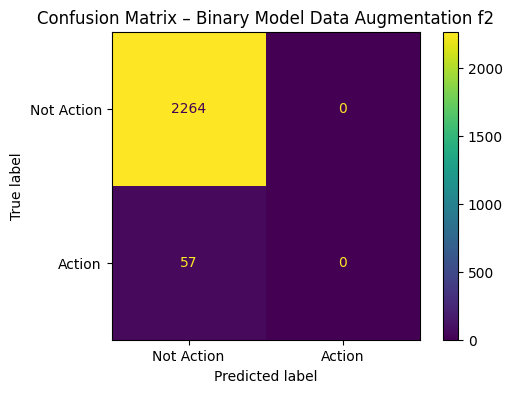


✅ Validation Accuracy: 0.98


In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import time
import random

timestamp = time.strftime("%Y%m%d-%H%M%S")

# 💾 Speicherpfade anlegen
checkpoint_dir = "/content/drive/MyDrive/mtb_project/checkpoints_global"
os.makedirs(checkpoint_dir, exist_ok=True)
final_model_dir = "/content/drive/MyDrive/mtb_project/final_models_global"
os.makedirs(final_model_dir, exist_ok=True)
report_dir = "/content/drive/MyDrive/mtb_project/reports_global"
os.makedirs(report_dir, exist_ok=True)


#Data Augmentation
def augment_time_series_multiclass(X, y, augment_factor=2, jitter_std=0.01, scale_range=(0.9, 1.1),
                                   permute_segments=3, apply_mixup=False, seed=42):
    np.random.seed(seed)
    random.seed(seed)

    N, T, F = X.shape
    X_aug = []
    y_aug = []

    def jitter(x):
        return x + np.random.normal(loc=0., scale=jitter_std, size=x.shape)

    def scale(x):
        factor = np.random.uniform(*scale_range)
        return x * factor

    def permute(x):
        segs = np.array_split(x, permute_segments)
        np.random.shuffle(segs)
        return np.concatenate(segs, axis=0)

    def hello_ruven():
      print("Hallo Ruven, du kleiner Schlawiner!")

    def mixup(x1, x2, y1, y2):
        alpha = np.random.beta(0.4, 0.4)
        x_mix = alpha * x1 + (1 - alpha) * x2
        return x_mix, y1 if np.random.rand() < 0.5 else y2

    for i in range(N):
        for _ in range(augment_factor):
            x_aug = X[i]

            if np.random.rand() < 0.5:
                x_aug = jitter(x_aug)
            if np.random.rand() < 0.5:
                x_aug = scale(x_aug)
            if np.random.rand() < 0.3:
                x_aug = permute(x_aug)

            if apply_mixup and np.random.rand() < 0.3:
                idx2 = np.random.randint(0, N)
                x_aug, y_mix = mixup(x_aug, X[idx2], y[i], y[idx2])
                y_aug.append(y_mix)
            else:
                y_aug.append(y[i])

            X_aug.append(x_aug)

    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)

    X_combined = np.concatenate([X, X_aug])
    y_combined = np.concatenate([y, y_aug])

    return X_combined, y_combined


# 1. Daten vorbereiten: alle Sessions zusammenführen
X_all = np.concatenate(sessions_X)
y_all = np.concatenate(sessions_y)

# 2. Labels binär umwandeln: "Action" = 1, alles andere = 0
y_all_binary = np.array([1 if label == "Action" else 0 for label in y_all])

# 3. Trainings- und Validierungsdaten splitten (z.B. 90% Training, 10% Validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all_binary, test_size=0.1, random_state=42, stratify=y_all_binary
)


# Augmentierung auf Trainingsdaten anwenden
X_train, y_train = augment_time_series_multiclass(X_train, y_train, augment_factor=2, jitter_std=0.01, scale_range=(0.9, 1.1),
                                   permute_segments=3, apply_mixup=False, seed=42)


# 4. Modell definieren (CNN + LSTM Architektur) - Binary Output: 1 Neuron mit Sigmoid
model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=X_train.shape[1:]),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(100, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Ein Output für Binary Classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 5. Callback für Checkpoints während Training
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "global_epoch_{epoch:02d}.keras"),
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# 6. Training starten
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[checkpoint_cb]
)

# 7. Finale Modell speichern
model.save(os.path.join(final_model_dir, "global_final_v4_binary_augment_f2.keras"))

# 8. Vorhersagen für Validierungsdaten (Wahrscheinlichkeiten)
y_pred_probs = model.predict(X_val)

# 9. Wahrscheinlichkeiten in Klassen (0 oder 1) umwandeln, Schwellenwert 0.5
y_pred_binary = (y_pred_probs >= 0.5).astype(int).reshape(-1)

# 10. Classification Report ausgeben
print("\n📄 Classification Report (Binary):\n")
report = classification_report(y_val, y_pred_binary, target_names=['Not Action', 'Action'])
print(report)

# 11. Report als Textdatei speichern
with open(os.path.join(report_dir, f"classification_report_augmentf2_binary_{timestamp}.txt"), "w") as f:
    f.write(report)

# 12. Confusion Matrix plotten und speichern
cm = confusion_matrix(y_val, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Action', 'Action'])
fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax)
plt.title("Confusion Matrix – Binary Model Data Augmentation f2")
plt.savefig(os.path.join(report_dir, f"conf_matrix_augment_f2_binary_{timestamp}.png"))
plt.show()

# 13. Evaluation auf Validierungsdaten
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"\n✅ Validation Accuracy: {val_acc:.2f}")


##Erklärung classification report

* Precision: Precision ist das Verhältnis der Anzahl von True Positives zur Gesamtzahl der positiven Vorhersagen. Wenn das Modell z. B. 100 Bäume erkannt hat und 90 korrekt gewesen wären, beträgt die Genauigkeit 90 Prozent.

Precision = (True Positive)/(True Positive + False Positive)

* Recall: Recall ist das Verhältnis der Anzahl von True Positives zur Gesamtzahl der realen (relevanten) Objekte. Wenn das Modell z. B. 75 Bäume auf einem Bild korrekt erkennt und es tatsächlich 100 Bäume auf dem Bild gibt, beträgt der Recall 75 Prozent.

Recall = (True Positive)/(True Positive + False Negative)

* F-Maß: Das F-Maß (auch "F1-Score") ist ein gewichteter Durchschnitt von Genauigkeit und Recall. Die Werte liegen zwischen 0 und 1, wobei 1 für die höchste Genauigkeit steht.

F-Maß = (Precision × Recall)/[(Precision + Recall)/2]

##Csv export

In [ ]:
#evtl speichern als csv oder oben integrieren
from sklearn.metrics import classification_report
import pandas as pd

# Ausgabe als Dictionary
report_dict = classification_report(y_val, y_pred_binary, target_names=['Not Action', 'Action'], output_dict=True)

# In DataFrame konvertieren
report_df = pd.DataFrame(report_dict).transpose()

# Speichern als CSV
report_df.to_csv(os.path.join(report_dir, f"classification_report_binary_{timestamp}.csv"))


#🧾 Zusammenfassung Modeltraining
##📊 1. Durchschnittliche Accuracy über alle Sessions:

ist oben in code integriert, funktioniert irgendwie nicht danacht

In [ ]:
#📊 1. Durchschnittliche Accuracy über alle Sessions:

mean_acc = np.mean(all_accuracies)
print("\n📈 Zusammenfassung:")
for i, acc in enumerate(all_accuracies):
    print(f"  Session {i+1}: Accuracy = {acc:.2f}")
print(f"\n✅ Durchschnittliche Test-Accuracy über alle Sessions: {mean_acc:.2f}")


##📁 2. CSV speichern (falls nicht schon vorhanden):

In [ ]:
#📁 2. CSV speichern (falls nicht schon vorhanden):

import pandas as pd

df_summary = pd.DataFrame(accuracy_summary)
df_summary['Session'] = [f"Session_{i+1}" for i in range(len(all_accuracies))]
df_summary.to_csv("/content/drive/MyDrive/mtb_project/session_accuracy_report.csv", index=False)
print("✅ Bericht gespeichert unter: session_accuracy_report.csv")


In [ ]:
os.makedirs("/content/drive/MyDrive/mtb_project/reports", exist_ok=True)


In [ ]:
from sklearn.metrics import classification_report
import io

# Klassifikationsbericht als Text speichern
report_text = classification_report(y_test_enc, y_pred_classes, target_names=le.classes_)
with open(f"/content/drive/MyDrive/mtb_project/reports/{sess_name}_classification_report.txt", "w") as f:
    f.write(report_text)



#confusion matrix als bild speicheern
fig, ax = plt.subplots(figsize=(8,6))
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp.plot(ax=ax, xticks_rotation=45)
plt.title(f"Confusion Matrix – {sess_name}")
plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/mtb_project/reports/{sess_name}_confusion_matrix.png")
plt.close()


🧾 Zusammenfassung nach dem Training:

Nach der Schleife kannst du am Ende folgendes hinzufügen, um einen Bericht zu erzeugen:

📊 Bonus: CSV speichern (optional)

In [ ]:

# Durchschnittliche Accuracy über alle Sessions
mean_acc = np.mean(all_accuracies)
print("\n📈 Zusammenfassung:")
for i, acc in enumerate(all_accuracies):
    print(f"  Session {i+1}: Accuracy = {acc:.2f}")
print(f"\n✅ Durchschnittliche Test-Accuracy über alle Sessions: {mean_acc:.2f}")



#📊 Bonus: CSV speichern (optional)

import pandas as pd

summary = {'Session': [], 'Accuracy': []}
for i, acc in enumerate(all_accuracies):
    summary['Session'].append(f"Session_{i+1}")
    summary['Accuracy'].append(acc)

df_summary = pd.DataFrame(summary)
df_summary.to_csv("session_accuracy_report.csv", index=False)
print("📁 Bericht gespeichert als session_accuracy_report.csv")




NameError: name 'all_accuracies' is not defined

#💾 II. Modell speichern & später wieder laden (z. B. nach Training)

##🔐 Speichern mit TensorFlow/**Keras**

In [ ]:
# Nach dem Training:
#speichert mit timestamp
#model.save("SenseCap_Eventdetection_Model.keras")  # speichert nur in colab kurzzeitig
import time
timestamp = time.strftime("%Y%m%d-%H%M%S")
model.save(f"/content/drive/MyDrive/ML-MTB-Modell/ML-Model_trained/SenseCap_Model_binary{timestamp}.keras")



##🔄 Laden

Das speichert das gesamte Modell inkl. Architektur, Gewichten und Optimizer-Zustand –exakt da weitermachen, wo man aufgehört hast.

In [ ]:


from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/ML-MTB-Modell/ML-Model_trained/SenseCap_Eventdetection_Model1.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 24 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
all_accuracies = []

for i in range(len(test_sessions_X)):
    X_test = test_sessions_X[i]
    y_test = test_sessions_y[i]

    _, acc = model.evaluate(X_test, y_test, verbose=0)
    all_accuracies.append(acc)


NameError: name 'test_sessions_X' is not defined

In [ ]:

# Durchschnittliche Accuracy über alle Sessions
mean_acc = np.mean(all_accuracies)
print("\n📈 Zusammenfassung:")
for i, acc in enumerate(all_accuracies):
    print(f"  Session {i+1}: Accuracy = {acc:.2f}")
print(f"\n✅ Durchschnittliche Test-Accuracy über alle Sessions: {mean_acc:.2f}")



#📊 Bonus: CSV speichern (optional)

import pandas as pd

summary = {'Session': [], 'Accuracy': []}
for i, acc in enumerate(all_accuracies):
    summary['Session'].append(f"Session_{i+1}")
    summary['Accuracy'].append(acc)

df_summary = pd.DataFrame(summary)
df_summary.to_csv("session_accuracy_report.csv", index=False)
print("📁 Bericht gespeichert als session_accuracy_report.csv")




NameError: name 'all_accuracies' is not defined